In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import itertools
import time
import os
import sys
import json
import pandas as pd
import h5py

# Import user defined libraries:
from FreeFEM import FFmatrix_fread, FFvector_fread

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_3140/3761569201.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_3140/3761569201.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


In [2]:
# Load coordinates:
coordinates_Px = FFvector_fread('mesh_utilities/vv_cc_Px.btxt')
coordinates_Pq = FFvector_fread('mesh_utilities/vv_cc_Pq.btxt')

# Identify degrees of freedom of the Px and Pq spaces:
sFO_Px = coordinates_Px.shape[0]
sFO_Pq = coordinates_Pq.shape[0]
print(rf'Degree of freedom = {sFO_Px}')

# Define vector of all Px indeces:
mask_all = np.arange(sFO_Px, dtype=int)

# Identify indeces of the top, bottom and middle boundaries in Px:
mask_inf_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_sup_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.ones((sFO_Px)))]
mask_mid_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_ext_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.ones((sFO_Px)))]

# Identify indeces of the Dirichlet b.c. for the temperature and concentration field:
mask_bc_T = np.fromiter(set(mask_sup_bc), int)
mask_bc_C = np.fromiter(set(mask_sup_bc) | set(mask_ext_bc) | set(mask_inf_bc), int)

# Identify indeces of the interior for the temperature and concentration field:
mask_in_T = [ii for ii in mask_all if ii not in mask_bc_T]
mask_in_C = [ii for ii in mask_all if ii not in mask_bc_C]

# Import mass matrices on the Px and on the Pq space:
mass_Px = FFmatrix_fread('mesh_utilities/ww_mm_Px.btxt')
mass_Pq = FFmatrix_fread('mesh_utilities/ww_mm_Pq.btxt')
mass_Pm = FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')

# Extract integration weights and diagonal matrix with their inverse:
weights_Pq = mass_Pq.diagonal()
project_Pq = sparse.diags(np.reciprocal(weights_Pq))

# Import map from Px to Pq and to the dx, dy, dz derivative evaluated in Pq:
PxtoPquu_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdx_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dx_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdy_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dy_Px_Pq.btxt')[:, mask_in_C])

# Define weights for the integration in polar coordinates:
polar_weights_Pq = np.multiply(coordinates_Pq[:, 0], weights_Pq)

# Compute volume of the domain:
volume = np.dot(np.ones(sFO_Pq), polar_weights_Pq)

# Assemble mass matrix and projected forcing term:
forc_C = PxtoPquu_C.T.dot(polar_weights_Pq[:, None])
mass_C = PxtoPquu_C.T.dot(PxtoPquu_C.multiply(polar_weights_Pq[:, None]))
inte_C = PxtoPquu_C.T.dot(polar_weights_Pq) / volume

Degree of freedom = 10201


# **FULL ORDER**

### XZ PLANE AT Y=0

1.6350430639629565e+25


/Users/martina/Library/Python/3.9/lib/python/site-packages/matplotlib/tri/_triangulation.py:181: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)


La quota z al valore massimo della concentrazione è: 0.982062 m


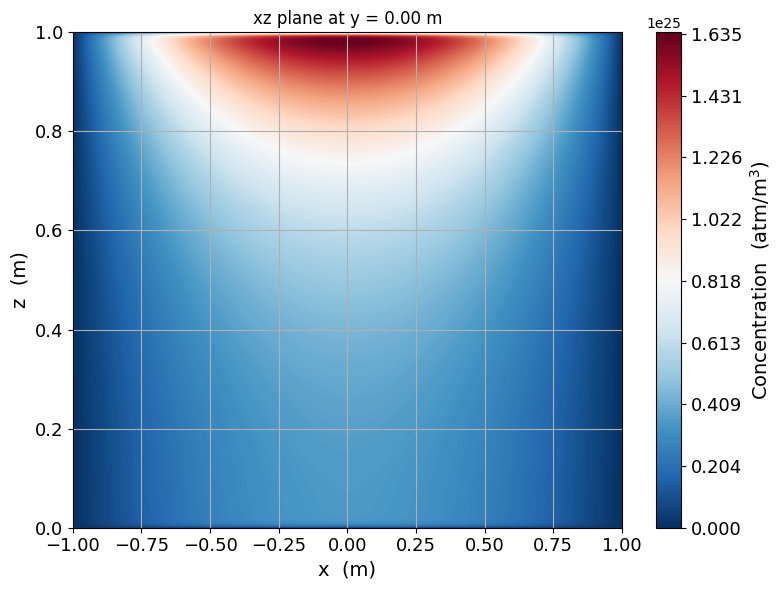

In [3]:
sol_new_C = np.loadtxt('reference case/Fullorder_Cfield.csv', delimiter=',')
field = sol_new_C[:, -1] / volume

field = np.hstack((field, field))
coord_x = np.hstack((coordinates_Px[:, 0], - coordinates_Px[:, 0]))
coord_z = np.hstack((coordinates_Px[:, 1],   coordinates_Px[:, 1]))

#Per farlo metà
#field = sol_new_C[:, -1] / volume
#coord_x = np.hstack((coordinates_Px[:, 0]))
#coord_y = np.hstack((coordinates_Px[:, 1]))

max_tick = np.max(field)
tick_step = 0.2e25
print(max_tick)
ticks = np.linspace(0, max_tick, int(max_tick / tick_step) + 1)

plt.figure(figsize=(8, 6))
contour = plt.tricontourf(coord_x, coord_z, field, 400, cmap='RdBu_r', vmin=0, vmax = max_tick)
cbar = plt.colorbar(contour, ticks=ticks)       # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('Concentration  (atm/m$^3$)', fontsize=14)
 
    
#plt.ylim((1-2e-2, 1))  #zoom sulla zona ad alto gradiente
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlabel('x  (m)',fontsize=14)
plt.ylabel('z  (m)',fontsize=14)
plt.title('xz plane at y = 0.00 m')
plt.grid(True)
plt.tight_layout()
plt.savefig('plot/reference case/FOM_xz.png', bbox_inches='tight')

# Trova la coordinata z a cui corrisponde il valore massimo della concentrazione
max_index = np.argmax(field)  # Indice del valore massimo
z_max = coord_z[max_index]  # Coordinata z del massimo valore
print(f"La quota z al valore massimo della concentrazione è: {z_max:.6f} m")

(10201,)
1.6350430639629565e+25


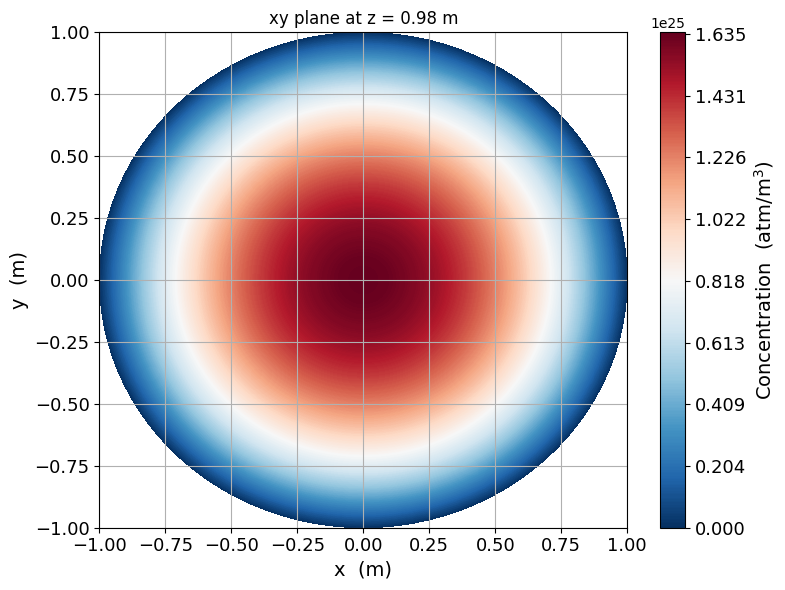

In [6]:
sol_new_C = np.loadtxt('reference case/Fullorder_Cfield.csv', delimiter=',')
field = sol_new_C[:, -1] / volume

field = sol_new_C[:, -1] / volume
coord_x = np.hstack((coordinates_Px[:, 0]))
coord_z = np.hstack((coordinates_Px[:, 1]))
print(coord_x.shape)

z_target = z_max
z_tolerance = 0.0001  # tolleranza per z_target
mask = np.abs(coord_z - z_target) < z_tolerance
filtered_x = coord_x[mask]  # valori di x corrispondenti a z = 0.5
filtered_field = field[mask]  # campo in corrispondenza di z = 0.5

theta = np.linspace(0, 2 * np.pi, len(filtered_x))
r = coord_x  # assumendo che x sia la coordinata radiale
R, T = np.meshgrid(filtered_x, theta)  # griglia cilindrica
X = R * np.cos(T)  # trasformazione in X cartesiana
Y = R * np.sin(T)  # trasformazione in Y cartesiana
field_rotated = np.tile(filtered_field, (len(theta), 1))


max_tick = np.max(field)
tick_step = 0.2e25
print(max_tick)
ticks = np.linspace(0, max_tick, int(max_tick / tick_step) + 1)

plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, field_rotated, 400, cmap='RdBu_r', vmin = 0, vmax = max_tick)
cbar = plt.colorbar(contour, ticks=ticks)       # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('Concentration  (atm/m$^3$)', fontsize=14)
 
    
#plt.ylim((1-2e-2, 1))  #zoom sulla zona ad alto gradiente
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlabel('x  (m)',fontsize=14)
plt.ylabel('y  (m)',fontsize=14)
plt.title('xy plane at z = 0.98 m')
plt.grid(True)
plt.tight_layout()
plt.savefig('plot/reference case/FOM_xy.pdf', bbox_inches='tight')

# **BASIS**

In [3]:
with h5py.File('checkpoint/matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    basis = hf['basis'][:]

print(basis.shape)
print(coordinates_Px.shape)

(9900, 118)
(10201, 2)


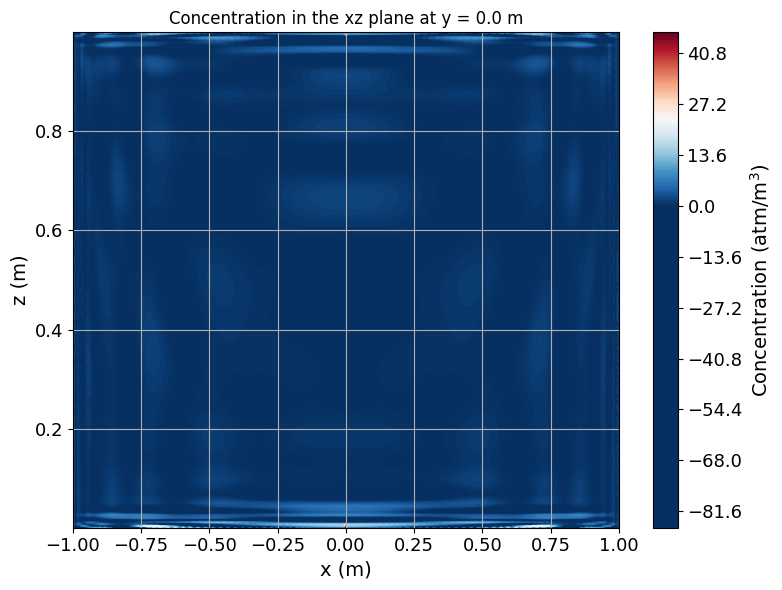

In [ ]:
basis_number = 117
field = basis[:, basis_number] 

field = np.hstack((field, field))
coord_x = np.hstack((coordinates_Px[mask_in_C, 0], - coordinates_Px[mask_in_C, 0]))
coord_z = np.hstack((coordinates_Px[mask_in_C, 1],   coordinates_Px[mask_in_C, 1]))

plt.figure(figsize=(8, 6))
contour = plt.tricontourf(coord_x, coord_z, field, 400, cmap='RdBu_r', vmin=0)
cbar = plt.colorbar(contour)       # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('Concentration (atm/m$^3$)', fontsize=14)

plt.title(f'Concentration in the xz plane at y = {0.00} m')
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlim([-1, 1])
plt.xlabel('x (m)',fontsize=14)
plt.ylabel('z (m)',fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig(f'plot/Basis number {basis_number}.pdf', bbox_inches='tight') 
